## Preprocessing of EMA Data

In [1]:
import os
import sys
import regex as re
# If your current working directory is the notebooks directory, use this:
notebook_dir = os.getcwd()  # current working directory
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
import glob
import pickle
from IPython.display import Markdown
from config import datapath, preprocessed_path

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline
import plotly.express as px


In [2]:


with open(preprocessed_path + '/ema_data.pkl', 'rb') as file:
    df_ema_framework = pickle.load(file)

with open(preprocessed_path + '/ema_content.pkl', 'rb') as file:
    df_ema_cont = pickle.load(file)  

with open(preprocessed_path + '/monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

In [3]:
min_num_daily = 1
min_days_data = 10

In [4]:
#df_ema = df_ema[['customer','study', 'createdAt', 'choice_id', 'choice_text',
#       'quest_title', 'questionnaire_name', 'ema_base_start', 'status',#
 #      'study_version']]

In [5]:
df_ema_content = df_ema_cont.copy()

In [6]:

df_ema_content['weekday'] = df_ema_content['quest_create'].dt.day_name()
df_ema_content['createdAt_day'] = df_ema_content.quest_create.dt.normalize()
# Convert columns to datetime
df_ema_content['createdAt_day'] = pd.to_datetime(df_ema_content['createdAt_day'])
df_ema_content['ema_base_start'] = pd.to_datetime(df_ema_content['ema_base_start'], dayfirst=True)
df_ema_content['ema_t20_start'] = pd.to_datetime(df_ema_content['ema_t20_start'], dayfirst=True)
df_ema_content['ema_post_start'] = pd.to_datetime(df_ema_content['ema_post_start'], dayfirst=True)


study_mapping = {
    24: 0,
    25: 0,
    33: 1,
    34: 1,
    38: 2,
    39: 2
}

# Apply the mapping to the 'study' column
df_ema_content['assess'] = df_ema_content['study'].map(study_mapping)
# Replace '_morning' with '' in the 'quest_title' column as we don't need to differenciate
df_ema_content['quest_title'] = df_ema_content['quest_title'].str.replace('_morning', '', regex=False)

df_ema_content['weekend'] = [1 if day in ['Saturday', 'Sunday'] else 0 for day in df_ema_content['weekday']]

df_ema_content['quest_nr'] = df_ema_content['questionnaire_name'].apply(lambda x: int(re.search(r'\d+', x).group()) \
                                               if re.search(r'\d+', x) else None)

df_ema_content["n_quest"] = df_ema_content.groupby(["study", "customer", "createdAt_day"])["questionnaire_name"].transform("nunique")

# Create unique day ID
# Create a unique day identifier directly without creating extra columns
df_ema_content['unique_day_id'] = df_ema_content['createdAt_day'].dt.strftime('%Y%m%d') + '_' + df_ema_content['quest_nr'].astype(str)

# Define the ema_relative_start and ema_relative_end for each phase
df_ema_content['ema_relative_start'] = df_ema_content.groupby(['customer', 'assess'])['createdAt_day'].transform('min')
df_ema_content['ema_relative_end'] = df_ema_content.groupby(['customer', 'assess'])['createdAt_day'].transform('max')

# Calculate the Absolute Day Index based on ema_relative_start
df_ema_content['absolute_day_index'] = (df_ema_content['createdAt_day'] - df_ema_content['ema_relative_start']).dt.days + 1

# Calculate the Relative Day Index by counting unique days since ema_relative_start
df_ema_content['relative_day_index'] = df_ema_content.groupby(['customer', 'assess'])['createdAt_day'].rank(method='dense').astype(int)

# Drop duplicate rows based on 'customer', 'assess', and 'createdAt_day' to ensure only one counter per unique day
df_unique = df_ema_content.drop_duplicates(subset=['customer', 'assess', 'unique_day_id']).copy()

# Use .loc to avoid SettingWithCopyWarning
df_unique['questionnaire_counter'] = df_unique.groupby(['customer', 'assess']).cumcount() + 1
df_unique['questionnaire_counter'] = df_unique.questionnaire_counter.astype(int)


# Merge this back into the original dataframe to retain other data if needed
df_ema_content = pd.merge(df_ema_content, df_unique[['customer', 'assess', 'unique_day_id', 'questionnaire_counter']],
                              on=['customer', 'assess', 'unique_day_id'], how='left')


### 1. Include only patients with finished assessments and enough data

In [7]:
df_ema = df_ema_content.loc[df_ema_content.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]

In [8]:
df_ema1 = df_ema.loc[df_ema.study.isin([24,25])] # first assessment phase
df_ema2 = df_ema.loc[df_ema.study.isin([33,34])] # second assessment phase
df_ema3 = df_ema.loc[df_ema.study.isin([33,34])] # third assessment phase


In [9]:
df_ema1 = df_ema1.loc[df_ema1["n_quest"] >= min_num_daily]
df_ema1["n_days_min"] = df_ema1.groupby("customer")["createdAt_day"].transform("nunique")
df_ema1 = df_ema1.loc[df_ema1.n_days_min >= min_days_data]
df_ema1_customers = df_ema1.customer.unique().tolist()

In [10]:
df_ema2 = df_ema2.loc[df_ema2["n_quest"] >= min_num_daily]
df_ema2["n_days_min"] = df_ema2.groupby("customer")["createdAt_day"].transform("nunique")
df_ema2 = df_ema2.loc[df_ema2.n_days_min >= min_days_data]
df_ema2_customers = df_ema2.customer.unique().tolist()

In [11]:
#keep only customers with sufficient data 
#df_ema_red = df_ema.loc[df_ema.customer.isin(df_ema2_customers)]
df_ema_red = df_ema.loc[df_ema.customer.isin(df_ema1_customers)]

### 2. Pivot table

In [12]:
df_sit = df_ema[df_ema.quest_title =="situation1"]

In [13]:
df_nosit = df_ema[df_ema['quest_title'] != 'situation1']

In [14]:
# Pivot the table as specified
df_sit = df_sit.pivot_table(
    index=["customer", "unique_day_id", "choice_id", "quest_create"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_sit.columns = [col for col in df_sit.columns.values]

# Reset the index to turn the MultiIndex into columns
df_sit = df_sit.reset_index()

# Number of selected situations per assessment
df_sit['situation_count'] = df_sit.groupby(["customer","unique_day_id"])["choice_id"].transform('count')


In [15]:
# Pivot the table as specified
df_piv = df_nosit.pivot_table(
    index=["customer", "unique_day_id", "assess", "quest_complete_day"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_piv.columns = [col for col in df_piv.columns.values]

# Reset the index to turn the MultiIndex into columns
df_piv = df_piv.reset_index()

# Keep only customers with complete assessment
df_piv_merged = df_piv.merge(df_sit, on=["customer", "unique_day_id"], how="right")

In [16]:
columns_to_convert = ['ecg_control', 'er_acceptance',
       'er_control', 'er_distraction', 'er_intensity', 'er_reappraisal',
       'er_relaxation', 'er_rumination', 'er_suppression', 'event_general',
       'event_social1', 'event_social2', 'event_social3',
       'panas_attentiveness', 'panas_fatigue', 'panas_fear1', 'panas_fear2',
       'panas_guilt1', 'panas_guilt2', 'panas_hostility1', 'panas_hostility2',
       'panas_joviality1', 'panas_joviality2', 'panas_loneliness',
       'panas_sadness1', 'panas_sadness2', 'panas_selfassurance',
       'panas_serenity1', 'panas_serenity2', 'panas_shyness',
       'physical_health', 'situation2', 'ta_behavioral',
       'ta_behavioral_2', 'ta_kognitiv', 'ta_kognitiv_2']

In [17]:
df_piv[columns_to_convert] = df_piv[columns_to_convert].apply(pd.to_numeric, errors='coerce')


### 3. Calculate average emotion regulation strategy use 

In [18]:
# Select columns that start with 'er_'
er_columns = [col for col in df_piv.columns if col.startswith('er_')]

# Group by 'customer' and 'study', then calculate the mean of the er_ columns
mean_er = df_piv.groupby(['customer', 'assess'])[er_columns].mean().reset_index()


In [19]:
mean_er = mean_er[['assess', 'er_acceptance', 'er_distraction', 'er_reappraisal', 'er_relaxation', 
                   'er_rumination','er_suppression']]

/var/folders/0h/35xd98js5ksdz62v9q7cwhwr0000gn/T/ipykernel_75912/196982761.py:16: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(x='Mean_Value', y='ER_Strategy', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)
/var/folders/0h/35xd98js5ksdz62v9q7cwhwr0000gn/T/ipykernel_75912/196982761.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Mean_Value', y='ER_Strategy', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)


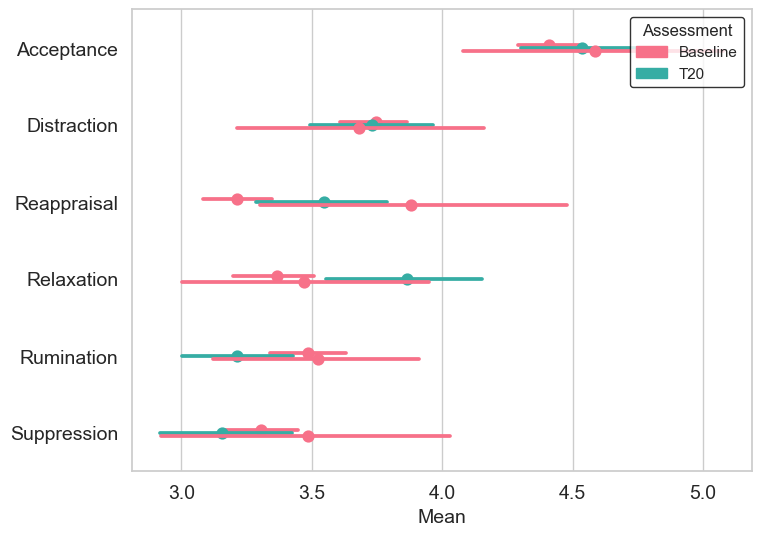

In [20]:

# Assuming your data is in a DataFrame called "mean_er"
melted_data = mean_er.melt(id_vars='assess', var_name='ER_Strategy', value_name='Mean_Value')
# Filter out non-numeric values in the 'Mean_Value' column
melted_data = melted_data[melted_data['Mean_Value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
melted_data['Mean_Value'] = pd.to_numeric(melted_data['Mean_Value'])

# Preprocess the ER strategies column to remove "er_" prefix and capitalize the names
melted_data['ER_Strategy'] = melted_data['ER_Strategy'].str.replace('er_', '').str.capitalize()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Define custom color palette
colors = sns.color_palette("husl", 2)

# Plotting using seaborn's pointplot with join=False to remove lines
sns.pointplot(x='Mean_Value', y='ER_Strategy', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)

plt.xlabel('Mean')
plt.ylabel('')

# Create custom legend with colored patches for each group
legend_colors = {'Baseline': colors[0], 'T20': colors[1]}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
plt.legend(handles=legend_patches, title='Assessment', loc='upper right', facecolor='white', edgecolor='black')

plt.savefig("er_strategy_plot.png", format="png")
plt.show()


### 4. Calculate average PANAS scores

In [21]:
panas_columns = [col for col in df_piv.columns if col.startswith('panas_')]

In [22]:
# Group by 'customer' and 'study', then calculate the mean of the panas_ columns
mean_panas = df_piv.groupby(['customer', 'assess'])[panas_columns].mean().reset_index()

/var/folders/0h/35xd98js5ksdz62v9q7cwhwr0000gn/T/ipykernel_75912/1756424739.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Mean_Value', y='PANAS', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)


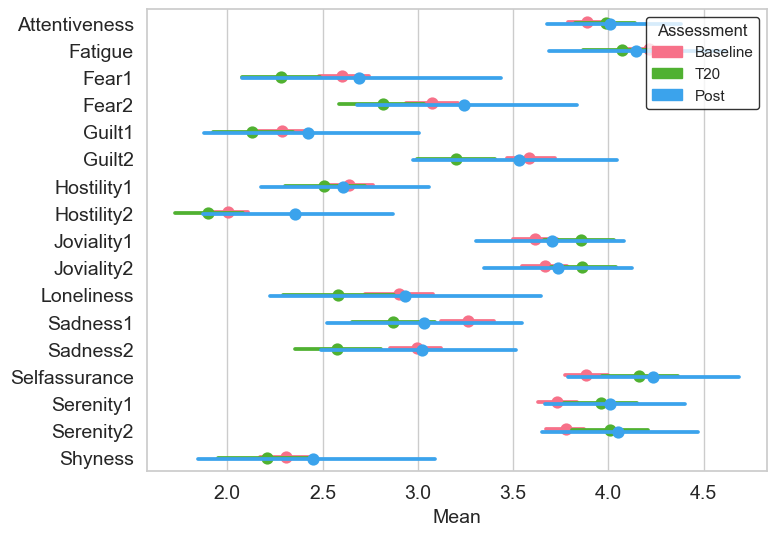

In [23]:
# Assuming your data is in a DataFrame called "mean_er"

melted_data = mean_panas.melt(id_vars='assess', var_name='PANAS', value_name='Mean_Value')
# Filter out non-numeric values in the 'Mean_Value' column
melted_data = melted_data[melted_data['Mean_Value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
melted_data['Mean_Value'] = pd.to_numeric(melted_data['Mean_Value'])

melted_data['PANAS'] = melted_data['PANAS'].str.replace('panas_', '').str.capitalize()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Define custom color palette
colors = sns.color_palette("husl", 3)

# Plotting using seaborn's pointplot with join=False to remove lines
sns.pointplot(x='Mean_Value', y='PANAS', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)

plt.xlabel('Mean')
plt.ylabel('')

# Create custom legend with colored patches for each group

legend_colors = {'Baseline': colors[0], 'T20': colors[1], 'Post': colors[2]}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
plt.legend(handles=legend_patches, title='Assessment', loc='upper right', facecolor='white', edgecolor='black')


### Combine EMA and BSI-GSI

In [24]:
#df_outcome = df_active[['customer', 'rci', 'clinically_significant', 'reliable_change',
#       'clinically_reliable_change']]
#df_outcome = df_outcome.drop_duplicates(subset="customer")

In [25]:
#df_outcome = df_outcome.merge(mean_panas, on="customer", how="inner")

### Check out TAI items

In [26]:
df_ema2 = df_ema2.loc[df_ema2.quest_title.isin(['ta_behavioral', 'ta_behavioral_2', 'ta_kognitiv', 'ta_kognitiv_2'])]

In [27]:
df_ema2[['quest_title', 'questionnaire_name', 'question', 'questionnaire']]

,quest_title,questionnaire_name,question,questionnaire
167672,ta_behavioral_2,TIKI_8_L1_S2,358,120
167673,ta_kognitiv,TIKI_8_L1_S2,359,120
167676,ta_kognitiv_2,TIKI_8_L1_S2,360,120
167678,ta_behavioral,TIKI_8_L1_S2,357,120
167711,ta_behavioral_2,TIKI_8_L1_S2,358,120
...,...,...,...,...
881733,ta_behavioral,TIKI_8_E1_S2,357,122
881836,ta_behavioral_2,TIKI_8_E2_S2,358,123
881837,ta_kognitiv,TIKI_8_E2_S2,359,123
881838,ta_kognitiv_2,TIKI_8_E2_S2,360,123


In [28]:
df_ema2.columns

Index(['customer', 'session_unique', 'questionnaire', 'study', 'question',
       'order', 'element', 'quest_create', 'choice_id', 'choice_text',
       'quest_title', 'questionnaire_name', 'quest_complete_day', 'for_id',
       'ema_id', 'study_version', 'status', 'Besonderes', 't20_post',
       'ema_base_start', 'ema_base_end', 'Terminpräferenz', 'first_call_date',
       'Wer führt 1. Gespräch?', 'Telefonat stattgefunden?',
       'Baseline T20 Update verschickt?', 'ema_t20_start', 'ema_t20_end',
       'ema_post_start', 'ema_post_end', 'Post T20 Update verschickt?',
       'Studienende/ Dropout Mail verschickt?', 'weekday', 'createdAt_day',
       'assess', 'weekend', 'quest_nr', 'n_quest', 'unique_day_id',
       'ema_relative_start', 'ema_relative_end', 'ema_relative_start_phase0',
       'ema_relative_end_phase0', 'ema_relative_start_phase1',
       'ema_relative_end_phase1', 'ema_relative_start_phase2',
       'ema_relative_end_phase2', 'absolute_day_index', 'relative_day_inde

In [29]:
# Pivot the table as specified
df_ema2_piv = df_ema2.pivot_table(
    index=["customer", "unique_day_id"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_ema2_piv.columns = [col for col in df_ema2_piv.columns.values]

# Reset the index to turn the MultiIndex into columns
df_ema2_piv = df_ema2_piv.reset_index()


In [30]:
ta_columns = [col for col in df_ema2_piv.columns if col.startswith('ta_')]


In [31]:
ta_count = df_ema2_piv.groupby("customer")["ta_behavioral"].count()

In [32]:
(ta_count > 5).sum()

np.int64(57)